In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import os
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt


In [3]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(device)

cuda


In [0]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

from torchvision.datasets import MNIST
download_root = './MNIST_DATASET'

batch_size = 32
train_dataset = MNIST(download_root, transform=transform, train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

tensor(2)


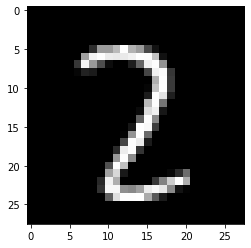

In [25]:
def imshow(img):
  img = img * 1.0 + 0.5
  img = img.numpy().reshape(28, 28)
  plt.imshow(img, cmap='gray')
  plt.show()

for num, data in enumerate(train_loader):
  x, y = data
  print(y[0])
  imshow(x[0])
  break

In [0]:
class generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fcc = nn.Sequential(
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 1024),
      nn.ReLU(),
      nn.Linear(1024, 784),
      nn.Tanh()
    )

  def forward(self, x):
    g_x = self.fcc(x)
    return g_x

class discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fcc = nn.Sequential(
        nn.Linear(784, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    d_x = self.fcc(x)
    return d_x

class GAN(nn.Module):
  def __init__(self, gen, dis):
    super().__init__()

    self.gen = gen
    self.dis = dis

  def forward(self, x):
    self.dis.eval()
    g_x = self.gen(x)
    d_g_x = self.dis(g_x)
    return d_g_x

In [0]:
gen = generator()
dis = discriminator()
gan = GAN(gen, dis)

In [0]:
gen.to(device)
dis.to(device)
gan.to(device)

dis_optimizer = optim.Adam(dis.parameters(), lr=4e-4)
gen_optimizer = optim.Adam(gen.parameters(), lr=4e-4)

loss_fn = nn.BCELoss()

def train_epoch(epoch):
  gen_losses = []
  dis_losses = []
  for step, data in enumerate(train_loader):
    x, y = data
    x = x.view([-1, 784]).to(device)
    
    z = np.random.normal(0, 1, size=[batch_size, 256])
    z = torch.from_numpy(z).float().to(device)
    g_z = gen(z)
    x = torch.cat([x, g_z], dim=0)
    y = torch.zeros([2 * batch_size, 1], dtype=torch.float)
    y[:batch_size,] = 0.9
    x = x.to(device)
    y = y.to(device)
    y_ = dis(x)

    gen.eval()
    dis.train()
    dis_optimizer.zero_grad()
    dis_loss = loss_fn(y_, y)
    dis_loss.backward()
    dis_optimizer.step()


    z = np.random.normal(0, 1, size=[batch_size, 256])
    z = torch.from_numpy(z).float().to(device)
    z = z.to(device)
    y = torch.ones([batch_size, 1], dtype=torch.float)
    y = y.to(device)
    f_g_z = gan(z)

    dis.eval()
    gen.train()
    gen_optimizer.zero_grad()
    gen_loss = loss_fn(f_g_z, y)
    gen_loss.backward()
    gen_optimizer.step()

    dis_losses.append(dis_loss.item())
    gen_losses.append(gen_loss.item())

  avg_dis_loss = np.mean(np.array(dis_losses))
  avg_gen_loss = np.mean(np.array(gen_losses))
  
  return avg_dis_loss, avg_gen_loss




In [0]:
def train(epochs):
  for epoch in trange(epochs):
    avg_dis_loss, avg_gen_loss = train_epoch(epoch)
    print(f'epoch {epoch} finished   ============> discriminator loss : {avg_dis_loss} ,  generator loss : {avg_gen_loss}')
    

In [89]:
train(50)




  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:16<13:36, 16.67s/it]

epoch 0 finished   ============> discriminator loss : 0.36959082079728445 ,  generator loss : 3.191073444112142





  4%|▍         | 2/50 [00:33<13:18, 16.64s/it]

epoch 1 finished   ============> discriminator loss : 0.35848773404757184 ,  generator loss : 3.2444339449564614





  6%|▌         | 3/50 [00:49<13:02, 16.64s/it]

epoch 2 finished   ============> discriminator loss : 0.35911864114602404 ,  generator loss : 3.274993815612793





  8%|▊         | 4/50 [01:06<12:46, 16.66s/it]

epoch 3 finished   ============> discriminator loss : 0.36131184260845184 ,  generator loss : 3.3787074055989583





 10%|█         | 5/50 [01:23<12:28, 16.64s/it]

epoch 4 finished   ============> discriminator loss : 0.3447928335348765 ,  generator loss : 3.5598043317159016





 12%|█▏        | 6/50 [01:39<12:09, 16.59s/it]

epoch 5 finished   ============> discriminator loss : 0.3437870421806971 ,  generator loss : 3.683852800432841





 14%|█▍        | 7/50 [01:56<11:52, 16.57s/it]

epoch 6 finished   ============> discriminator loss : 0.34558870565891264 ,  generator loss : 3.587820207818349





 16%|█▌        | 8/50 [02:12<11:37, 16.60s/it]

epoch 7 finished   ============> discriminator loss : 0.3340362421512604 ,  generator loss : 3.8652395369847614





 18%|█▊        | 9/50 [02:29<11:20, 16.60s/it]

epoch 8 finished   ============> discriminator loss : 0.3382368808825811 ,  generator loss : 3.6690419907887777





 20%|██        | 10/50 [02:45<11:02, 16.57s/it]

epoch 9 finished   ============> discriminator loss : 0.3385858075618744 ,  generator loss : 3.8194588357925414





 22%|██▏       | 11/50 [03:02<10:50, 16.69s/it]

epoch 10 finished   ============> discriminator loss : 0.34785610127449035 ,  generator loss : 3.6783736831029255





 24%|██▍       | 12/50 [03:19<10:30, 16.60s/it]

epoch 11 finished   ============> discriminator loss : 0.35357405784130097 ,  generator loss : 3.5101806701660156





 26%|██▌       | 13/50 [03:35<10:13, 16.59s/it]

epoch 12 finished   ============> discriminator loss : 0.35132737038930256 ,  generator loss : 3.6057301537831625





 28%|██▊       | 14/50 [03:52<09:56, 16.58s/it]

epoch 13 finished   ============> discriminator loss : 0.3478829884052277 ,  generator loss : 3.651593582566579





 30%|███       | 15/50 [04:08<09:38, 16.54s/it]

epoch 14 finished   ============> discriminator loss : 0.3498559666554133 ,  generator loss : 3.6050499027252196





 32%|███▏      | 16/50 [04:25<09:20, 16.50s/it]

epoch 15 finished   ============> discriminator loss : 0.3505083286523819 ,  generator loss : 3.5799777072906496





 34%|███▍      | 17/50 [04:41<09:03, 16.48s/it]

epoch 16 finished   ============> discriminator loss : 0.35514107637405395 ,  generator loss : 3.626491071828206





 36%|███▌      | 18/50 [04:58<08:49, 16.55s/it]

epoch 17 finished   ============> discriminator loss : 0.365710790125529 ,  generator loss : 3.5104841885884603





 38%|███▊      | 19/50 [05:14<08:33, 16.55s/it]

epoch 18 finished   ============> discriminator loss : 0.3635370376586914 ,  generator loss : 3.506605707327525





 40%|████      | 20/50 [05:31<08:16, 16.55s/it]

epoch 19 finished   ============> discriminator loss : 0.3526536432902018 ,  generator loss : 3.550261170641581





 42%|████▏     | 21/50 [05:47<07:58, 16.51s/it]

epoch 20 finished   ============> discriminator loss : 0.3532055457512538 ,  generator loss : 3.5982156253178914





 44%|████▍     | 22/50 [06:04<07:41, 16.48s/it]

epoch 21 finished   ============> discriminator loss : 0.3501310779571533 ,  generator loss : 3.6137417209625244





 46%|████▌     | 23/50 [06:20<07:25, 16.51s/it]

epoch 22 finished   ============> discriminator loss : 0.35367623845736185 ,  generator loss : 3.4807484160105386





 48%|████▊     | 24/50 [06:37<07:08, 16.48s/it]

epoch 23 finished   ============> discriminator loss : 0.3560707566022873 ,  generator loss : 3.468041355514526





 50%|█████     | 25/50 [06:53<06:51, 16.46s/it]

epoch 24 finished   ============> discriminator loss : 0.36148977200190224 ,  generator loss : 3.4339320152282715





 52%|█████▏    | 26/50 [07:10<06:35, 16.47s/it]

epoch 25 finished   ============> discriminator loss : 0.36415187908013663 ,  generator loss : 3.378564603106181





 54%|█████▍    | 27/50 [07:26<06:19, 16.50s/it]

epoch 26 finished   ============> discriminator loss : 0.3563995519955953 ,  generator loss : 3.4978362084706625





 56%|█████▌    | 28/50 [07:43<06:04, 16.57s/it]

epoch 27 finished   ============> discriminator loss : 0.35415223513444266 ,  generator loss : 3.4109006045659385





 58%|█████▊    | 29/50 [08:00<05:47, 16.55s/it]

epoch 28 finished   ============> discriminator loss : 0.3592173204342524 ,  generator loss : 3.3706510254542033





 60%|██████    | 30/50 [08:16<05:32, 16.64s/it]

epoch 29 finished   ============> discriminator loss : 0.36100848768552146 ,  generator loss : 3.3868972403844197





 62%|██████▏   | 31/50 [08:33<05:15, 16.60s/it]

epoch 30 finished   ============> discriminator loss : 0.35805986309846244 ,  generator loss : 3.313282735125224





 64%|██████▍   | 32/50 [08:49<04:57, 16.53s/it]

epoch 31 finished   ============> discriminator loss : 0.3590769296725591 ,  generator loss : 3.3835681674957274





 66%|██████▌   | 33/50 [09:06<04:41, 16.54s/it]

epoch 32 finished   ============> discriminator loss : 0.3570276493469874 ,  generator loss : 3.3631996498743693





 68%|██████▊   | 34/50 [09:22<04:23, 16.48s/it]

epoch 33 finished   ============> discriminator loss : 0.35087210383415224 ,  generator loss : 3.4146476081848145





 70%|███████   | 35/50 [09:39<04:07, 16.48s/it]

epoch 34 finished   ============> discriminator loss : 0.3598105952739716 ,  generator loss : 3.2507442178726196





 72%|███████▏  | 36/50 [09:55<03:50, 16.46s/it]

epoch 35 finished   ============> discriminator loss : 0.35257731278737386 ,  generator loss : 3.406141533788045





 74%|███████▍  | 37/50 [10:12<03:33, 16.46s/it]

epoch 36 finished   ============> discriminator loss : 0.3546697632948558 ,  generator loss : 3.3010983486175536





 76%|███████▌  | 38/50 [10:28<03:18, 16.50s/it]

epoch 37 finished   ============> discriminator loss : 0.35577051474253335 ,  generator loss : 3.3002708729426065





 78%|███████▊  | 39/50 [10:45<03:01, 16.48s/it]

epoch 38 finished   ============> discriminator loss : 0.3582133907477061 ,  generator loss : 3.2201601167678833





 80%|████████  | 40/50 [11:01<02:44, 16.46s/it]

epoch 39 finished   ============> discriminator loss : 0.35575064670244855 ,  generator loss : 3.2969978902816774





 82%|████████▏ | 41/50 [11:17<02:28, 16.47s/it]

epoch 40 finished   ============> discriminator loss : 0.35557888412475586 ,  generator loss : 3.3542873964945477





 84%|████████▍ | 42/50 [11:34<02:11, 16.47s/it]

epoch 41 finished   ============> discriminator loss : 0.3542333778858185 ,  generator loss : 3.2845235597610474





 86%|████████▌ | 43/50 [11:50<01:55, 16.49s/it]

epoch 42 finished   ============> discriminator loss : 0.3548484158595403 ,  generator loss : 3.257998995335897





 88%|████████▊ | 44/50 [12:07<01:38, 16.46s/it]

epoch 43 finished   ============> discriminator loss : 0.3522347055673599 ,  generator loss : 3.2853147563298544





 90%|█████████ | 45/50 [12:23<01:22, 16.51s/it]

epoch 44 finished   ============> discriminator loss : 0.35352860253651935 ,  generator loss : 3.2999862140655516





 92%|█████████▏| 46/50 [12:40<01:05, 16.50s/it]

epoch 45 finished   ============> discriminator loss : 0.3495595553000768 ,  generator loss : 3.3894673184076947





 94%|█████████▍| 47/50 [12:56<00:49, 16.51s/it]

epoch 46 finished   ============> discriminator loss : 0.3520625392993291 ,  generator loss : 3.325262381998698





 96%|█████████▌| 48/50 [13:13<00:33, 16.56s/it]

epoch 47 finished   ============> discriminator loss : 0.35280281127293905 ,  generator loss : 3.2453757324854533





 98%|█████████▊| 49/50 [13:30<00:16, 16.65s/it]

epoch 48 finished   ============> discriminator loss : 0.3489015999396642 ,  generator loss : 3.3178805452982583





100%|██████████| 50/50 [13:46<00:00, 16.54s/it]

epoch 49 finished   ============> discriminator loss : 0.3508651894569397 ,  generator loss : 3.27093058274587


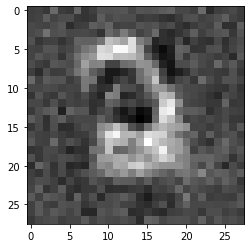

In [94]:
z = np.random.normal(0, 1, size=[1, 256])
z = torch.from_numpy(z).float().to(device)

g_z = gen(z)
imshow(g_z.to('cpu').detach())